# Student Performance - Models

## Set Up Environment

In [1]:
# Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read CSV file into a dataframe.
scores = pd.read_csv('data/StudentsPerformance_Polished.csv')
scores.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math score gender mean,math score gender median,...,"reading score ('lunch', 'test preparation course') min","reading score ('lunch', 'test preparation course') max","reading score ('lunch', 'test preparation course') stdev","reading score ('lunch', 'test preparation course') count","writing score ('lunch', 'test preparation course') mean","writing score ('lunch', 'test preparation course') median","writing score ('lunch', 'test preparation course') min","writing score ('lunch', 'test preparation course') max","writing score ('lunch', 'test preparation course') stdev","writing score ('lunch', 'test preparation course') count"
0,female,group B,bachelor's degree,standard,none,72,72,74,63.633205,65,...,26,100,13.752776,418,67.595694,69,22,100,14.238182,418
1,female,group C,some college,standard,completed,69,90,88,63.633205,65,...,41,100,12.800101,227,76.766520,77,41,100,12.535017,227
2,female,group B,master's degree,standard,none,90,95,93,63.633205,65,...,26,100,13.752776,418,67.595694,69,22,100,14.238182,418


## Define Classes

In [3]:
class Data_Processing:
    """
    This class is for cleaning data and preparing it for modeling.
    
    Attributes:
        data (dataframe): The pandas dataframe supplied when initiating a process_data object.
    """
    
    def __init__(self, data):
        """This method is the constructor for the process_data class."""
        self.data = data
    
    def label_encode(self, col, map_dict):
        """This method converts categorical variables to numeric based on hierarchy, defined by the map_dict parameter."""
        self.data[col] = self.data[col].map(map_dict)
    
    def one_hot_encode(self, col, drop_first=True):
        """This method converts non-hierarchical categorical variables to dummy variables."""
        self.data = pd.get_dummies(self.data, columns=[col], drop_first=drop_first)
        
    def drop_columns(self, cols):
        """This method drops a single or a list of columns."""
        self.data.drop(cols, axis=1, inplace=True)
    
    def transform(self, col, new_col, function):
        """This method uses a function to convert the values in an existing column to new values in a new column."""
        self.data[new_col] = self.data[col].apply(function)
    
    def convert_to_bool(self, string):
        """This method creates an indicator value from a string."""
        if string == 'NONE':
            return 0
        else:
            return 1
    
    def normalize(self, col, new_col):
        """This method scales numeric variables to 0-1 range."""
        self.data[new_col] = preprocessing.Normalizer(norm='max').transform([self.data[col]])[0]

In [4]:
class Model:
    """
    This class is for building a model, training it, and using it to make predictions.
    
    Attributes:
        model_type: The type of model used to make predictions.  This is provided when instantiating the object.
        data (dataframe): The pandas dataframe used to train the model and use it for predictions.
        features (list): The variables used by the model to make predictions.
        target: The value the model aims to predict.
        model: The model after it has been fitted to the training data.
    """
    
    def __init__(self, model_type, data, features, target, model_name):
        """This method is the constructor for the model class."""
        self.model = model_type
        self.data = data
        self.features = features
        self.target = target
        self.name = model_name
    
    def build_model(self, compare_df, test_size=.2):
        """This method splits the dataframe into training and test sets, trains the model on the training data, 
        makes predictions on the test set, and saves metrics in the compare_df dataframe."""
        
        # Split data set into training and test sets based on the test_size parameter
        features_train, features_test, target_train, target_test = train_test_split(
            self.data[self.features], self.data[self.target], test_size=test_size)
        
        # Fit the model to the training data and save the score as a variable
        self.model = self.model.fit(features_train, target_train)
        training_r2 = self.model.score(features_train, target_train)
        
        # Make predictions on the test set and save the R^2 and MSE scores as variables
        predicted_target = self.model.predict(features_test)
        test_r2 = r2_score(y_true=target_test, y_pred=predicted_target)
        mse = mean_squared_error(y_true=target_test, y_pred=predicted_target)
        rmse = mse**.5
        
        # Add the 3 scores to the compare_df (given as an argument)
        compare_df.loc[self.name] = [training_r2, test_r2, rmse, 0]
        
        return self.model
    
    def cross_validate(self, cv, compare_df, scoring='neg_mean_squared_error'):
        """This method runs cross validation on the dataset."""
        neg_mse = cross_val_score(self.model, self.data[self.features], self.data[self.target],  cv=cv, scoring=scoring)
        avg_mse = sum(neg_mse) / len(neg_mse) * -1.0
        avg_rmse = avg_mse**.5
        compare_df.loc[self.name, 'Cross Validation Score'] = avg_rmse
    
    def get_coefficients(self, test_size=.2):
        """This method gets the coefficients of the model and displays them as a series."""
        features_train, features_test, target_train, target_test = train_test_split(
            self.data[self.features], self.data[self.target], test_size=test_size)
        self.model = self.model.fit(features_train, target_train)
        coefficients = pd.Series(self.model.coef_, index=features_train.columns).sort_values(ascending=False)
        return coefficients
    
    def predict(self, data):
        """This method makes predictions on the given dataset."""
        predictions = self.model.predict(data)
        return predictions

In [5]:
class Compare:
    """
    This class is for comparing the results of different models.
    
    Attributes:
        data (dataframe): The pandas dataframe supplied when initiating a compare object.
    """
    
    def __init__(self, df):
        """This method is the constructor for the compare class."""
        self.data = df
    
    def graph_results(self, col, name, figsize=(7,4), left_margin=.4):
        """This method creates a bar graph of a given column of the dataframe and saves it as a jpg file."""
        
        metric_compare = self.data[col].sort_values()
        graph_title = col.replace('_',' ')
        file_name = 'charts/model_comparison_{}.jpg'.format(name)
        
        fig, ax = plt.subplots(figsize=figsize)
        fig.subplots_adjust(left=left_margin)
        ax.barh(metric_compare.index, metric_compare)
        ax.set_title(graph_title)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.savefig(file_name)

## Prepare Data for Modeling

In [6]:
# Set up column lists based on the type of data processing needed.

category_cols = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']

student_performance_cols = ['math score', 'reading score', 'writing score']
student_performance_norm_cols = ['math score norm', 'reading score norm', 'writing score norm']

group_metric_cols = list(scores.columns)
for col in (category_cols + student_performance_cols + ['parental level of education']):
    group_metric_cols.remove(col)

In [7]:
# Run through data processing steps: normalizing numeric columns, converting ordered categorical columns to numbers, and
# converting non-ordered categorical columns to dummy variables.

model_data = Data_Processing(scores)

for i in range(len(student_performance_cols)):
    model_data.normalize(student_performance_cols[i], student_performance_norm_cols[i])

for col in group_metric_cols:
    model_data.normalize(col, col)

level_of_education_map = {
    "some high school": 1,
    "high school": 2,
    "some college": 3,
    "associate's degree": 4,
    "bachelor's degree": 5,
    "master's degree": 6
}
model_data.label_encode('parental level of education', level_of_education_map)

for col in category_cols:
    model_data.one_hot_encode(col)

In [8]:
model_data.data.head(2)

,parental level of education,math score,reading score,writing score,math score gender mean,math score gender median,math score gender min,math score gender max,math score gender stdev,math score gender count,...,math score norm,reading score norm,writing score norm,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_standard,test preparation course_none
0,5,72,72,74,0.925867,0.942029,0.0,1.0,1.0,1.0,...,0.72,0.72,0.74,0,1,0,0,0,1,1
1,3,69,90,88,0.925867,0.942029,0.0,1.0,1.0,1.0,...,0.69,0.90,0.88,0,0,1,0,0,1,0


## Build Models

In [9]:
# Instantiate objects for each type of model and set up comparison dataframes.

lin_reg = linear_model.LinearRegression()
lasso_reg = linear_model.Lasso(alpha=.4)
ridge_reg = linear_model.Ridge(alpha=.4)
svm_reg = LinearSVR(epsilon=2, C=30)
rf_reg = RandomForestRegressor(n_estimators=25, max_depth=4, max_features=None)
gb_reg = GradientBoostingRegressor(n_estimators=25, max_depth=4)

feature_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Root Mean Squared Error', 'Cross Validation Score'])
model_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Root Mean Squared Error', 'Cross Validation Score'])

### Finding the Right Features

In [10]:
# Set up different groups of features to run through models.

experimental_features1m = ['reading score norm', 'writing score norm']
experimental_features1r = ['math score norm', 'writing score norm']
experimental_features1w = ['math score norm', 'reading score norm']
experimental_features2 = ['gender_male', 'race/ethnicity_group B', 'race/ethnicity_group C', 'race/ethnicity_group D', 
                         'race/ethnicity_group E', 'parental level of education', 'lunch_standard', 
                         'test preparation course_none']
experimental_features3 = group_metric_cols

#### Predicting Math Score

In [11]:
# Set up features and target for predicting math performance.
math_features = list(model_data.data.columns)

remove_cols = ['math score', 'reading score', 'writing score', 'math score norm']
for col in remove_cols:
    math_features.remove(col)

math_target = 'math score'

In [12]:
# Build models for each combination of features.

lreg_m_e1 = Model(lin_reg, model_data.data, experimental_features1m, math_target, 'Linear Regression - Math - E1 - Other Scores')
lreg_m_e1.build_model(feature_compare)
lreg_m_e1.cross_validate(4, feature_compare)

lreg_m_e2 = Model(lin_reg, model_data.data, experimental_features2, math_target, 'Linear Regression - Math - E2 - Individual Demographic')
lreg_m_e2.build_model(feature_compare)
lreg_m_e2.cross_validate(4, feature_compare)

lreg_m_e3 = Model(lin_reg, model_data.data, experimental_features3, math_target, 'Linear Regression - Math - E3 - Group')
lreg_m_e3.build_model(feature_compare)
lreg_m_e3.cross_validate(4, feature_compare)

lreg_m_e12 = Model(lin_reg, model_data.data, (experimental_features1m + experimental_features2), math_target, 'Linear Regression - Math - E1 + E2')
lreg_m_e12.build_model(feature_compare)
lreg_m_e12.cross_validate(4, feature_compare)

lreg_m_e13 = Model(lin_reg, model_data.data, (experimental_features1m + experimental_features3), math_target, 'Linear Regression - Math - E1 + E3')
lreg_m_e13.build_model(feature_compare)
lreg_m_e13.cross_validate(4, feature_compare)

lreg_m_e23 = Model(lin_reg, model_data.data, (experimental_features2 + experimental_features3), math_target, 'Linear Regression - Math - E2 + E3')
lreg_m_e23.build_model(feature_compare)
lreg_m_e23.cross_validate(4, feature_compare)

lreg_m = Model(lin_reg, model_data.data, math_features, math_target, 'Linear Regression - Math - All')
lreg_m.build_model(feature_compare)
lreg_m.cross_validate(4, feature_compare)

In [13]:
feature_compare

,Training_R2,Test_R2,Root Mean Squared Error,Cross Validation Score
Linear Regression - Math - E1 - Other Scores,0.677077,0.660813,8.869447,8.662657
Linear Regression - Math - E2 - Individual Demographic,0.244078,0.274487,13.233973,13.194254
Linear Regression - Math - E3 - Group,0.302798,0.021218,14.158401,13.889394
Linear Regression - Math - E1 + E2,0.876484,0.872189,5.427609,5.377648
Linear Regression - Math - E1 + E3,0.875691,0.888725,5.203521,5.637485
Linear Regression - Math - E2 + E3,0.279435,0.192201,13.882704,13.916018
Linear Regression - Math - All,0.883123,0.856754,5.355874,5.638312


#### Predicting Reading Score

In [14]:
# Set up features and target for predicting reading performance.
reading_features = list(model_data.data.columns)

remove_cols = ['math score', 'reading score', 'writing score', 'reading score norm']
for col in remove_cols:
    reading_features.remove(col)

reading_target = 'reading score'

In [15]:
# Build models for each combination of features.

lreg_r_e1 = Model(lin_reg, model_data.data, experimental_features1r, reading_target, 'Linear Regression - Reading - E1 - Other Scores')
lreg_r_e1.build_model(feature_compare)
lreg_r_e1.cross_validate(4, feature_compare)

lreg_r_e2 = Model(lin_reg, model_data.data, experimental_features2, reading_target, 'Linear Regression - Reading - E2 - Individual Demographic')
lreg_r_e2.build_model(feature_compare)
lreg_r_e2.cross_validate(4, feature_compare)

lreg_r_e3 = Model(lin_reg, model_data.data, experimental_features3, reading_target, 'Linear Regression - Reading - E3 - Group')
lreg_r_e3.build_model(feature_compare)
lreg_r_e3.cross_validate(4, feature_compare)

lreg_r_e12 = Model(lin_reg, model_data.data, (experimental_features1r + experimental_features2), reading_target, 'Linear Regression - Reading - E1 + E2')
lreg_r_e12.build_model(feature_compare)
lreg_r_e12.cross_validate(4, feature_compare)

lreg_r_e13 = Model(lin_reg, model_data.data, (experimental_features1r + experimental_features3), reading_target, 'Linear Regression - Reading - E1 + E3')
lreg_r_e13.build_model(feature_compare)
lreg_r_e13.cross_validate(4, feature_compare)

lreg_r_e23 = Model(lin_reg, model_data.data, (experimental_features2 + experimental_features3), reading_target, 'Linear Regression - Reading - E2 + E3')
lreg_r_e23.build_model(feature_compare)
lreg_r_e23.cross_validate(4, feature_compare)

lreg_r = Model(lin_reg, model_data.data, reading_features, reading_target, 'Linear Regression - Reading - All')
lreg_r.build_model(feature_compare)
lreg_r.cross_validate(4, feature_compare)

In [16]:
feature_compare

,Training_R2,Test_R2,Root Mean Squared Error,Cross Validation Score
Linear Regression - Math - E1 - Other Scores,0.677077,0.660813,8.869447,8.662657
Linear Regression - Math - E2 - Individual Demographic,0.244078,0.274487,13.233973,13.194254
Linear Regression - Math - E3 - Group,0.302798,0.021218,14.158401,13.889394
Linear Regression - Math - E1 + E2,0.876484,0.872189,5.427609,5.377648
Linear Regression - Math - E1 + E3,0.875691,0.888725,5.203521,5.637485
Linear Regression - Math - E2 + E3,0.279435,0.192201,13.882704,13.916018
Linear Regression - Math - All,0.883123,0.856754,5.355874,5.638312
Linear Regression - Reading - E1 - Other Scores,0.919283,0.915629,4.162857,4.169676
Linear Regression - Reading - E2 - Individual Demographic,0.243104,0.120768,12.757170,12.957475
Linear Regression - Reading - E3 - Group,0.258086,0.115950,12.973363,13.634396


#### Predicting Writing Score

In [17]:
# Set up features and target for predicting writing performance.
writing_features = list(model_data.data.columns)

remove_cols = ['math score', 'reading score', 'writing score', 'writing score norm']
for col in remove_cols:
    writing_features.remove(col)

writing_target = 'writing score'

In [18]:
# Build models for each combination of features.

lreg_w_e1 = Model(lin_reg, model_data.data, experimental_features1w, writing_target, 'Linear Regression - Writing - E1 - Other Scores')
lreg_w_e1.build_model(feature_compare)
lreg_w_e1.cross_validate(4, feature_compare)

lreg_w_e2 = Model(lin_reg, model_data.data, experimental_features2, writing_target, 'Linear Regression - Writing - E2 - Individual Demographic')
lreg_w_e2.build_model(feature_compare)
lreg_w_e2.cross_validate(4, feature_compare)

lreg_w_e3 = Model(lin_reg, model_data.data, experimental_features3, writing_target, 'Linear Regression - Writing - E3 - Group')
lreg_w_e3.build_model(feature_compare)
lreg_w_e3.cross_validate(4, feature_compare)

lreg_w_e12 = Model(lin_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Linear Regression - Writing - E1 + E2')
lreg_w_e12.build_model(feature_compare)
lreg_w_e12.cross_validate(4, feature_compare)

lreg_w_e13 = Model(lin_reg, model_data.data, (experimental_features1w + experimental_features3), writing_target, 'Linear Regression - Writing - E1 + E3')
lreg_w_e13.build_model(feature_compare)
lreg_w_e13.cross_validate(4, feature_compare)

lreg_w_e23 = Model(lin_reg, model_data.data, (experimental_features2 + experimental_features3), writing_target, 'Linear Regression - Writing - E2 + E3')
lreg_w_e23.build_model(feature_compare)
lreg_w_e23.cross_validate(4, feature_compare)

lreg_w = Model(lin_reg, model_data.data, writing_features, writing_target, 'Linear Regression - Writing - All')
lreg_w.build_model(feature_compare)
lreg_w.cross_validate(4, feature_compare)

In [19]:
feature_compare

,Training_R2,Test_R2,Root Mean Squared Error,Cross Validation Score
Linear Regression - Math - E1 - Other Scores,0.677077,0.660813,8.869447,8.662657
Linear Regression - Math - E2 - Individual Demographic,0.244078,0.274487,13.233973,13.194254
Linear Regression - Math - E3 - Group,0.302798,0.021218,14.158401,13.889394
Linear Regression - Math - E1 + E2,0.876484,0.872189,5.427609,5.377648
Linear Regression - Math - E1 + E3,0.875691,0.888725,5.203521,5.637485
Linear Regression - Math - E2 + E3,0.279435,0.192201,13.882704,13.916018
Linear Regression - Math - All,0.883123,0.856754,5.355874,5.638312
Linear Regression - Reading - E1 - Other Scores,0.919283,0.915629,4.162857,4.169676
Linear Regression - Reading - E2 - Individual Demographic,0.243104,0.120768,12.757170,12.957475
Linear Regression - Reading - E3 - Group,0.258086,0.115950,12.973363,13.634396


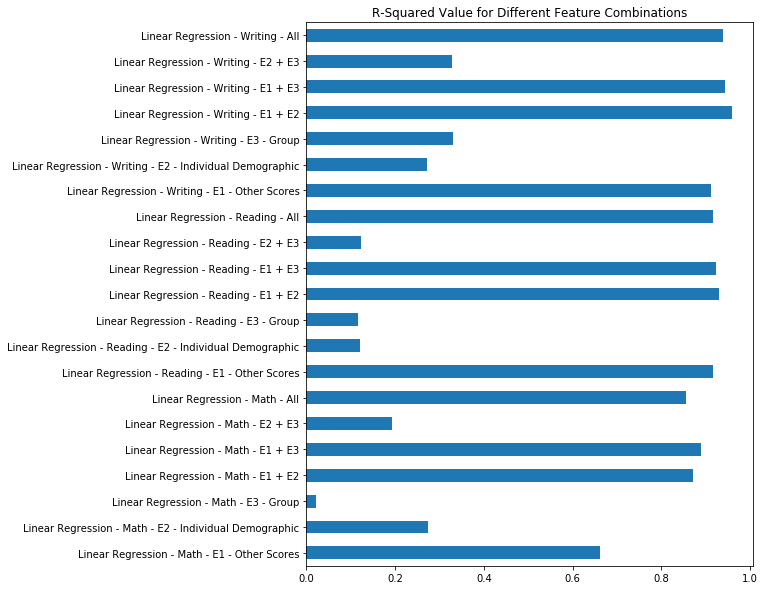

In [20]:
# Graph model results
feature_compare.Test_R2.plot.barh(figsize=(8,10), legend=False,
                                          title='R-Squared Value for Different Feature Combinations')
plt.savefig('charts/feature_comparison.jpg')

### Comparing Models

In [21]:
# Build models for each type of machine learning algorithm.

lreg_w = Model(lin_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Linear Regression - Writing')
lreg_w.build_model(model_compare)
lreg_w.cross_validate(4, model_compare)

lassoreg_w = Model(lasso_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Lasso Regression - Writing')
lassoreg_w.build_model(model_compare)
lassoreg_w.cross_validate(4, model_compare)

ridgereg_w = Model(ridge_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Ridge Regression - Writing')
ridgereg_w.build_model(model_compare)
ridgereg_w.cross_validate(4, model_compare)

svm_w = Model(svm_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Support Vector Machine - Writing')
svm_w.build_model(model_compare)
svm_w.cross_validate(4, model_compare)

rf_w = Model(rf_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Random Forest - Writing')
rf_w.build_model(model_compare)
rf_w.cross_validate(4, model_compare)

gb_w = Model(gb_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Gradient Boosting - Writing')
gb_w.build_model(model_compare)
gb_w.cross_validate(4, model_compare)

/home/antiri/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/antiri/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/antiri/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/antiri/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/antiri/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [22]:
model_compare

,Training_R2,Test_R2,Root Mean Squared Error,Cross Validation Score
Linear Regression - Writing,0.947060,0.948170,3.322597,3.546872
Lasso Regression - Writing,0.905927,0.900194,4.750171,4.706064
Ridge Regression - Writing,0.945473,0.952044,3.354370,3.558898
Support Vector Machine - Writing,0.945904,0.951086,3.441362,3.559780
Random Forest - Writing,0.929967,0.879099,4.847266,4.488724
Gradient Boosting - Writing,0.944713,0.925553,4.126263,4.174190


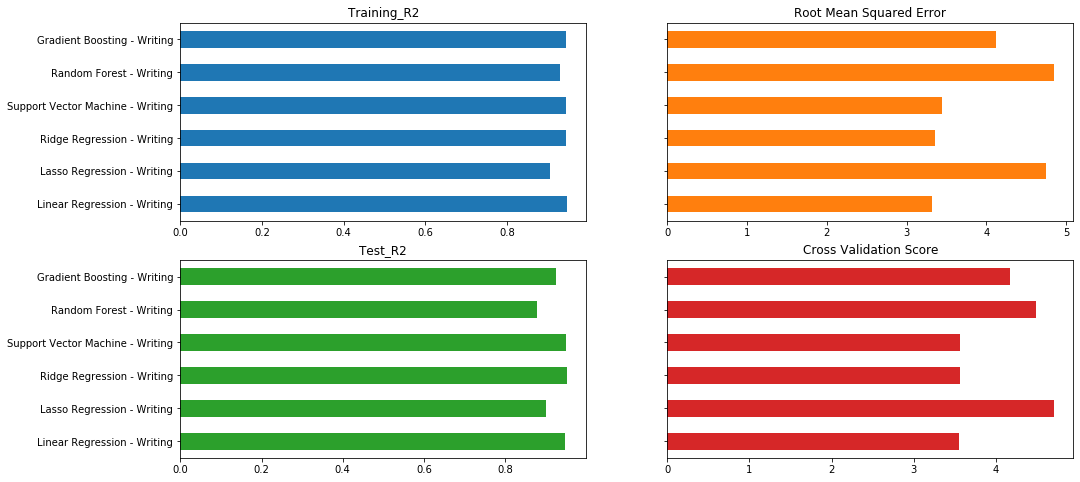

In [23]:
# Graph model results
model_compare.iloc[:,[0,2,1,3]].plot.barh(subplots=True, layout=(2,2), figsize=(16,8), 
                                          sharex=False, sharey=True, legend=False)
plt.savefig('charts/model_comparison.jpg')

The Ridge regression performed the best so I will select that as the production model.

## Finalizing Production Model

In [24]:
# Run whole model process for production model.

prod_models = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Root Mean Squared Error', 'Cross Validation Score'])

ridge_m = Model(ridge_reg, model_data.data, (experimental_features1m + experimental_features2), math_target, 'Ridge Regression - Math')
ridge_m.build_model(prod_models)
ridge_m.cross_validate(4, prod_models)

ridge_r = Model(ridge_reg, model_data.data, (experimental_features1r + experimental_features2), reading_target, 'Ridge Regression - Reading')
ridge_r.build_model(prod_models)
ridge_r.cross_validate(4, prod_models)

ridge_w = Model(ridge_reg, model_data.data, (experimental_features1w + experimental_features2), writing_target, 'Ridge Regression - Writing')
ridge_w.build_model(prod_models)
ridge_w.cross_validate(4, prod_models)

In [25]:
prod_models

,Training_R2,Test_R2,Root Mean Squared Error,Cross Validation Score
Ridge Regression - Math,0.872706,0.885861,5.226490,5.387938
Ridge Regression - Reading,0.922625,0.931259,3.785900,4.063920
Ridge Regression - Writing,0.941287,0.962646,3.353145,3.558898


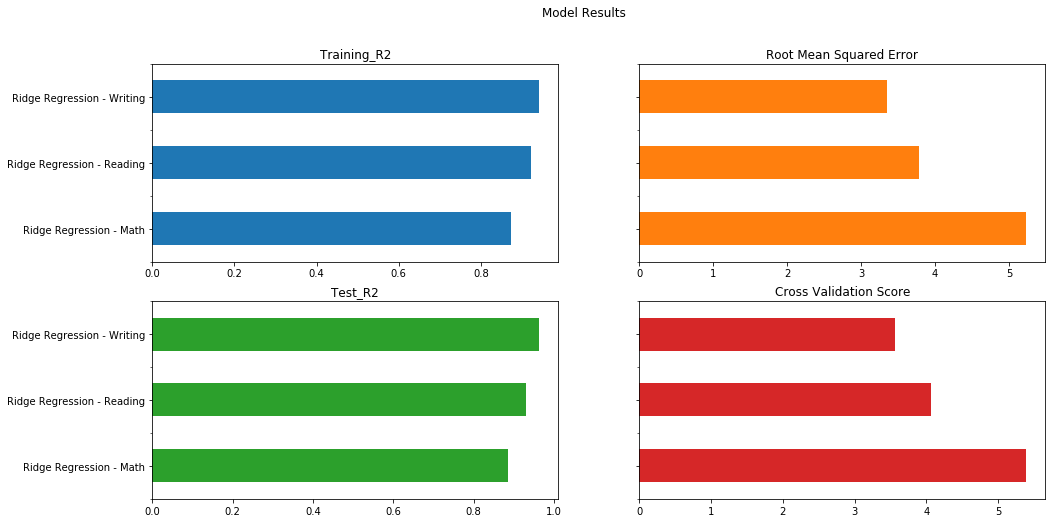

In [26]:
# Graph model results
prod_models.iloc[:,[0,2,1,3]].plot.barh(subplots=True, layout=(2,2), figsize=(16,8), sharex=False,
                                        sharey=True, legend=False, title='Model Results')
plt.savefig('charts/final_model_results.jpg')

In [27]:
# Display coefficients of math model.
ridge_m.get_coefficients().head(2)

writing score norm    60.125211
reading score norm    35.103202
dtype: float64

In [28]:
# Display coefficients of reading model.
ridge_r.get_coefficients().head(2)

writing score norm    73.327281
math score norm       23.849964
dtype: float64

In [29]:
# Display coefficients of writing model.
ridge_w.get_coefficients().head(2)

reading score norm    60.713936
math score norm       32.043670
dtype: float64